# Logistic Regression 

In [1]:
import numpy as np
import pickle
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
def get_train_test_inds(y,train_proportion=0.7):
    '''Generates indices, making random stratified split into training set and testing sets
    with proportions train_proportion and (1-train_proportion) of initial sample.
    y is any iterable indicating classes of each observation in the sample.
    Initial proportions of classes inside training and 
    testing sets are preserved (stratified sampling).
    '''

    y=np.array(y)
    train_inds = np.zeros(len(y),dtype=bool)
    test_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y)
    for value in values:
        value_inds = np.nonzero(y==value)[0]
        np.random.shuffle(value_inds)
        n = int(train_proportion*len(value_inds))

        train_inds[value_inds[:n]]=True
        test_inds[value_inds[n:]]=True

    return train_inds,test_inds

# Подготовка датасета

In [234]:
with open('./hw_1_train.pickle', 'rb') as f:
    train = pickle.load(f)

with open('./hw_1_test_no_lables.pickle', 'rb') as f:
    test_no_lables = pickle.load(f)
    
train_ind, test_ind = get_train_test_inds(train['labels'])
train_x, test_x, train_y, test_y = train['data'][train_ind], train['data'][test_ind], train['labels'][train_ind], \
train['labels'][test_ind]

train_x = train_x.T
test_x = test_x.T

train_y[np.where(train_y == 5)[0]] = 0
train_y[np.where(train_y == 6)[0]] = 1

train_y = train_y.reshape((1, -1))

test_y[np.where(test_y == 5)[0]] = 0
test_y[np.where(test_y == 6)[0]] = 1

test_y = test_y.reshape((1,-1))

In [235]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(784, 6999)
(1, 6999)
(784, 3001)
(1, 3001)


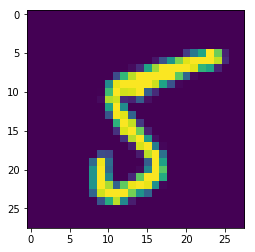

In [236]:
plt.imshow(train['data'][0].reshape(28,28))

## 3 - General Architecture of the learning algorithm ##

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

## 4 - Building the parts of our algorithm ## 

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - Helper functions

In [237]:
def compute_acc(y_true, y_pred):
    
    assert(y_true.shape[0] == 1 and y_pred.shape[0] == 1 and y_true.shape[1] == y_pred.shape[1] and
          len(y_true.shape) == 2 and len(y_pred.shape) == 2)
    
    acc = 0.0
    y_pred = np.array([1 if i > 0.5 else 0 for i in y_pred.reshape(-1)]).reshape((1, -1))
    for y_t, y_p in zip(y_true.reshape(-1), y_pred.reshape(-1)):
        if(y_t == y_p):
            acc += 1.0
    return acc / y_true.shape[1]

In [238]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1. / (1. + np.exp(-z))
    
    return s

### 4.2 - Initializing parameters

In [239]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    return np.zeros(shape=(dim, 1)), 0

In [240]:
def compute_cost(AL, Y, eps=1e-15, indexes=None, w=None, lamda=0):
    """
    Implement logloss

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector, shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    if w is None:
        w = 0
        
    if not indexes:
        m = Y.shape[1]
        
        # Compute loss from aL and y.
        cost = (1./m) * (-np.dot(Y,np.log(AL + eps).T) - np.dot(1-Y, np.log(1-AL + eps).T)) + lamda * np.dot(w.T, w)

    else:
        m = len(indexes)
        
        cost = (1./m) * (-np.dot(Y[:, indexes],np.log(AL[:, indexes] + eps).T) - \
                         np.dot(1-Y[:, indexes], np.log(1-AL[:, indexes] + eps).T)) + lamda * np.dot(w.T, w)
        
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())

    return cost

### 4.3 - Forward and Backward propagation


Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(0)}, a^{(1)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [247]:
def propagate(w, b, X, Y, mini_batch_size, lamda):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (..., 1)
    b -- bias, a scalar
    X -- data of size (..., number of examples)
    Y -- true "label" vector containing 0 or 1 of size (1, number of examples)
    mini_batch_size -- procent(float number from 0 to 1) of data to use in gradient descent

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    """
    m = X.shape[1] #number of examples
    assert(w.shape == (X.shape[0], 1))
    
    #forward step
    A = sigmoid(np.dot(w.T, X) + b)
    cost = compute_cost(A, Y, w=w, lamda=lamda)
    preds = predict(w, b, X, False)
    acc = compute_acc(Y, preds)
    
    A_test = sigmoid(np.dot(w.T, test_x) + b)
    cost_test = compute_cost(A_test, test_y, w=w, lamda=lamda)
    preds_test = predict(w, b, test_x, False)
    acc_test = compute_acc(test_y, preds_test)
   
    #backward step
    #choose indexes to implement SGD
    m_minibatch = int(mini_batch_size * m)
    indexes = np.random.randint(0, m, m_minibatch)   
    
    dz = A[:, indexes] - Y[:, indexes]
    db = 1./m_minibatch * np.sum(dz)
    dw = 1./m_minibatch * np.dot(X[:, indexes], dz.T) + lamda * w


    grads = {"dw": dw,
             "db": db}

    return grads, cost, cost_test,acc, acc_test

In [242]:
d.keys()

dict_keys(['costs', 'costs_test', 'acc', 'acc_test', 'Y_prediction_test', 'Y_prediction_train', 'w', 'b', 'learning_rate', 'num_iterations'])

### Optimization

In [243]:
def optimize(w, b, X, Y, num_iterations, learning_rate, mini_batch_size, lamda, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (..., 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector containing 0 or 1 of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    """
    
    costs = []
    costs_test = []
    acc_list = []
    acc_test_list = []
    for iter_num in range(1, num_iterations + 1):
        grads, cost, cost_test, acc, acc_test = propagate(w, b, X, Y, mini_batch_size, lamda)
        dw = grads['dw']
        db = grads['db']
        
        _learning_rate = learning_rate / iter_num
        w = w - _learning_rate * dw
        b = b - _learning_rate * db
    
        costs.append(cost)
        costs_test.append(cost_test)
        acc_list.append(acc)
        acc_test_list.append(acc_test)
        
        if print_cost and iter_num % 100 == 0:
            print ("Cost after iteration %i: %f" % (iter_num, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs, costs_test, acc_list, acc_test_list

In [244]:
def predict(w, b, X, prob=True):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (..., 1)
    b -- bias, a scalar
    X -- data of size (..., number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    A = sigmoid(np.dot(w.T, X) + b)
    if prob:
        return A
    else:
        Y_prediction = np.zeros((1, X.shape[1]))
        for i in range(A.shape[1]):
            Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
        
        return Y_prediction

## 5 - Model ##

In [245]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, lamda=0.1, 
          mini_batch_size=0.1, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    w, b = initialize_with_zeros(X_train.shape[0])
    parameters, grads, costs, costs_test, acc, acc_test = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, 
                                                                   mini_batch_size, lamda, print_cost)
    
    w = parameters["w"]
    b = parameters["b"]
    
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "costs_test": costs_test,
         "acc": acc,
         "acc_test": acc_test,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [248]:
d = model(train_x, train_y, test_x, test_y, num_iterations = 2000, learning_rate = 0.0005, lamda=0.2, mini_batch_size=0.5, print_cost = True)

Cost after iteration 100: 0.558350
Cost after iteration 200: 0.527272
Cost after iteration 300: 0.511300
Cost after iteration 400: 0.500540
Cost after iteration 500: 0.492407
Cost after iteration 600: 0.486146
Cost after iteration 700: 0.481135
Cost after iteration 800: 0.476728
Cost after iteration 900: 0.472820
Cost after iteration 1000: 0.469460
Cost after iteration 1100: 0.466476
Cost after iteration 1200: 0.463733
Cost after iteration 1300: 0.461280
Cost after iteration 1400: 0.459049
Cost after iteration 1500: 0.457025
Cost after iteration 1600: 0.455058
Cost after iteration 1700: 0.453277
Cost after iteration 1800: 0.451587
Cost after iteration 1900: 0.450008
Cost after iteration 2000: 0.448523
train accuracy: 96.80461960675942 %
test accuracy: 96.91106992958593 %


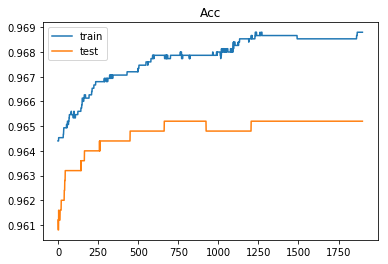

In [201]:
plt.title('Acc')
plt.plot([e for e in d['acc'][100:]], label='train')
plt.plot([e for e in d['acc_test'][100:]], label='test')
plt.legend()

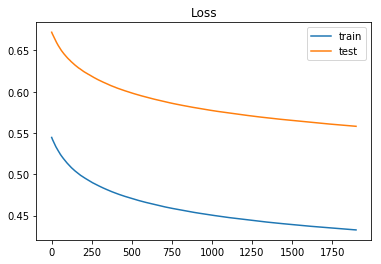

In [202]:
plt.title('Loss')
plt.plot([e for e in d['costs'][100:]], label='train')
plt.plot([e for e in d['costs_test'][100:]], label='test')
plt.legend()

In [204]:
answers = predict(d["w"], d["b"], test_no_lables["data"].T).reshape(-1)
with open('solution.csv', 'w') as fout:
    print("Id,Prediction", file=fout)
    for i in range(test_no_lables["data"].shape[0]):
        print(i, answers[i], sep=',', file=fout)